# ***START***

# Import Necessary Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os
import cv2
import random

#Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Read Dataset

In [3]:
df = pd.read_csv('/content/drive/MyDrive/DatasetForColab/EthnicLanguage/BdEthnicLanguages.csv')

In [4]:
df.head()

,Converted Text,Language
0,𑄃𑄬𑄇𑄴 𑄎𑄧𑄚𑄴 𑄝𑄪𑄢𑄦 𑄟𑄚𑄪 𑄝𑄎𑄢𑄬 𑄃𑄇𑄴𑄑 𑄥𑄧𑄠𑄴𑄥𑄴𑄛𑄨𑄥𑄴 𑄘𑄪𑄘𑄪𑄇𑄮...,Chakma
1,𑄝𑄉𑄚𑄴 𑄇𑄮𑄢𑄨𑄠 𑄛𑄢𑄴𑄝𑄮𑄑𑄬𑄢𑄴 𑄣𑄉𑄮𑄑𑄴 𑄘𑄮𑄢𑄨 𑄘𑄮𑄢𑄨 𑄃𑄇𑄴𑄑 𑄌𑄨𑄑𑄨...,Chakma
2,𑄝𑄨𑄣𑄃𑄨 𑄚𑄮𑄘𑄨𑄢𑄴 𑄘𑄢𑄬 𑄃𑄇𑄴𑄑 𑄉𑄪𑄛𑄴𑄑𑄮 𑄇𑄮𑄑𑄦 𑄥𑄪𑄚𑄴𑄘𑄮𑄢 𑄝𑄝𑄬 ...,Chakma
3,𑄘𑄇𑄴𑄑𑄢𑄴 𑄝𑄎𑄢𑄬 𑄅𑄖𑄴𑄥𑄦𑄬 𑄃𑄇𑄴𑄑 𑄉𑄌𑄮𑄢𑄴 𑄝𑄦𑄨𑄣𑄮।,Chakma
4,𑄝𑄉𑄚𑄴 𑄇𑄮𑄢𑄨𑄠 𑄛𑄢𑄴𑄇𑄣𑄬 𑄘𑄮𑄢𑄨 𑄘𑄮𑄢𑄨 𑄃𑄇𑄴𑄑 𑄉𑄃𑄚𑄴 𑄃𑄁𑄇𑄨𑄣𑄮।,Chakma


In [5]:
df.shape

(4713, 2)

In [6]:
df['Language'].value_counts().reset_index()

,Language,count
0,Chakma,1057
1,Marma,966
2,Rakhine,906
3,Santali,869
4,Garo,822
5,Tripura,93


In [7]:
df = df[df['Language'] != 'Tripura']

In [8]:
df['Language'].value_counts().reset_index()

,Language,count
0,Chakma,1057
1,Marma,966
2,Rakhine,906
3,Santali,869
4,Garo,822


In [9]:
max_count = df['Language'].value_counts().max()
max_count

1057

#Model Trianing

In [10]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Parameters
MAX_LEN = 300  # max number of characters per sample
CHAR_VOCAB = sorted(list(set(''.join(df['Converted Text']))))
char2idx = {c: i+1 for i, c in enumerate(CHAR_VOCAB)}  # reserve 0 for padding

# Encode text as character indices
def encode_text(text):
    return [char2idx.get(c, 0) for c in text[:MAX_LEN]]

X = df['Converted Text'].apply(encode_text).tolist()
X = pad_sequences(X, maxlen=MAX_LEN, padding='post')

# Encode labels
le = LabelEncoder()
y = le.fit_transform(df['Language'])
y = to_categorical(y)

print("✅ Text and labels encoded!")


✅ Text and labels encoded!


In [11]:
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score, f1_score

class MetricsCallback(Callback):
    def on_train_begin(self, logs=None):
        self.acc = []
        self.precision = []
        self.recall = []
        self.f1 = []
        self.val_acc = []
        self.val_precision = []
        self.val_recall = []
        self.val_f1 = []

    def on_epoch_end(self, epoch, logs=None):
        y_train_pred = np.argmax(self.model.predict(X_train, verbose=0), axis=1)
        y_train_true = np.argmax(y_train, axis=1)
        y_val_pred = np.argmax(self.model.predict(X_val, verbose=0), axis=1)
        y_val_true = np.argmax(y_val, axis=1)

        self.acc.append(accuracy_score(y_train_true, y_train_pred))
        self.precision.append(precision_score(y_train_true, y_train_pred, average='macro'))
        self.recall.append(recall_score(y_train_true, y_train_pred, average='macro'))
        self.f1.append(f1_score(y_train_true, y_train_pred, average='macro'))

        self.val_acc.append(accuracy_score(y_val_true, y_val_pred))
        self.val_precision.append(precision_score(y_val_true, y_val_pred, average='macro'))
        self.val_recall.append(recall_score(y_val_true, y_val_pred, average='macro'))
        self.val_f1.append(f1_score(y_val_true, y_val_pred, average='macro'))

metrics_callback = MetricsCallback()

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

model = Sequential([
    Embedding(input_dim=210, output_dim=64, input_shape=(300,) ),
    Conv1D(128, 5, activation='relu'),
    Dropout(0.3),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 300, 64)        │        13,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 296, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 296, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,109 (246.52 KB)

 Trainable params: 63,109 (246.52 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
from re import VERBOSE
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.222, random_state=42)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[
        metrics_callback,
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
        ]
)


Epoch 1/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 0.5429 - loss: 1.2011 - val_accuracy: 0.8550 - val_loss: 0.3284 - learning_rate: 0.0010
Epoch 2/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - accuracy: 0.8513 - loss: 0.3271 - val_accuracy: 0.9102 - val_loss: 0.2204 - learning_rate: 0.0010
Epoch 3/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.9046 - loss: 0.2413 - val_accuracy: 0.9210 - val_loss: 0.1824 - learning_rate: 0.0010
Epoch 4/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - accuracy: 0.9286 - loss: 0.1828 - val_accuracy: 0.9318 - val_loss: 0.1706 - learning_rate: 0.0010
Epoch 5/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.9347 - loss: 0.1658 - val_accuracy: 0.9351 - val_loss: 0.1579 - learning_rate: 0.0010
Epoch 6/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - accuracy: 0.9396 - loss: 0.1552 - val_accuracy: 0.9329 - val_loss: 0.1561 - learning_rate: 0.0010
Epoch 7/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 0.9

In [16]:
model.save('/content/drive/MyDrive/Training_Progress/BDEthnicV2.keras')

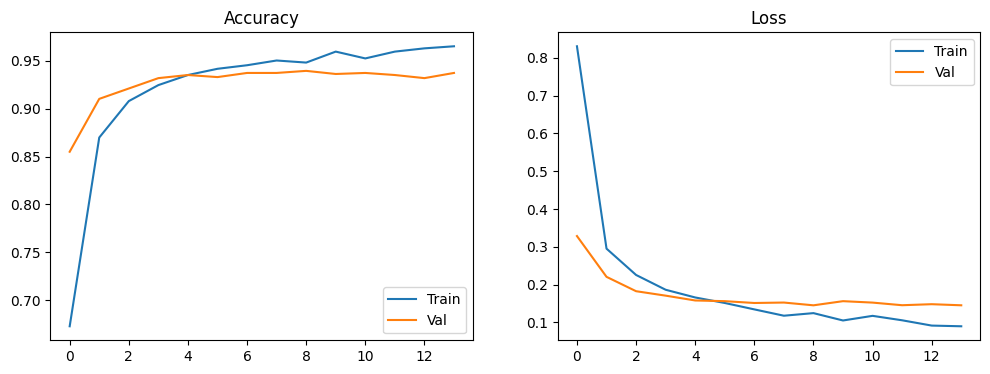

In [17]:
import matplotlib.pyplot as plt

# Accuracy and loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("Loss")
plt.legend()

plt.show()


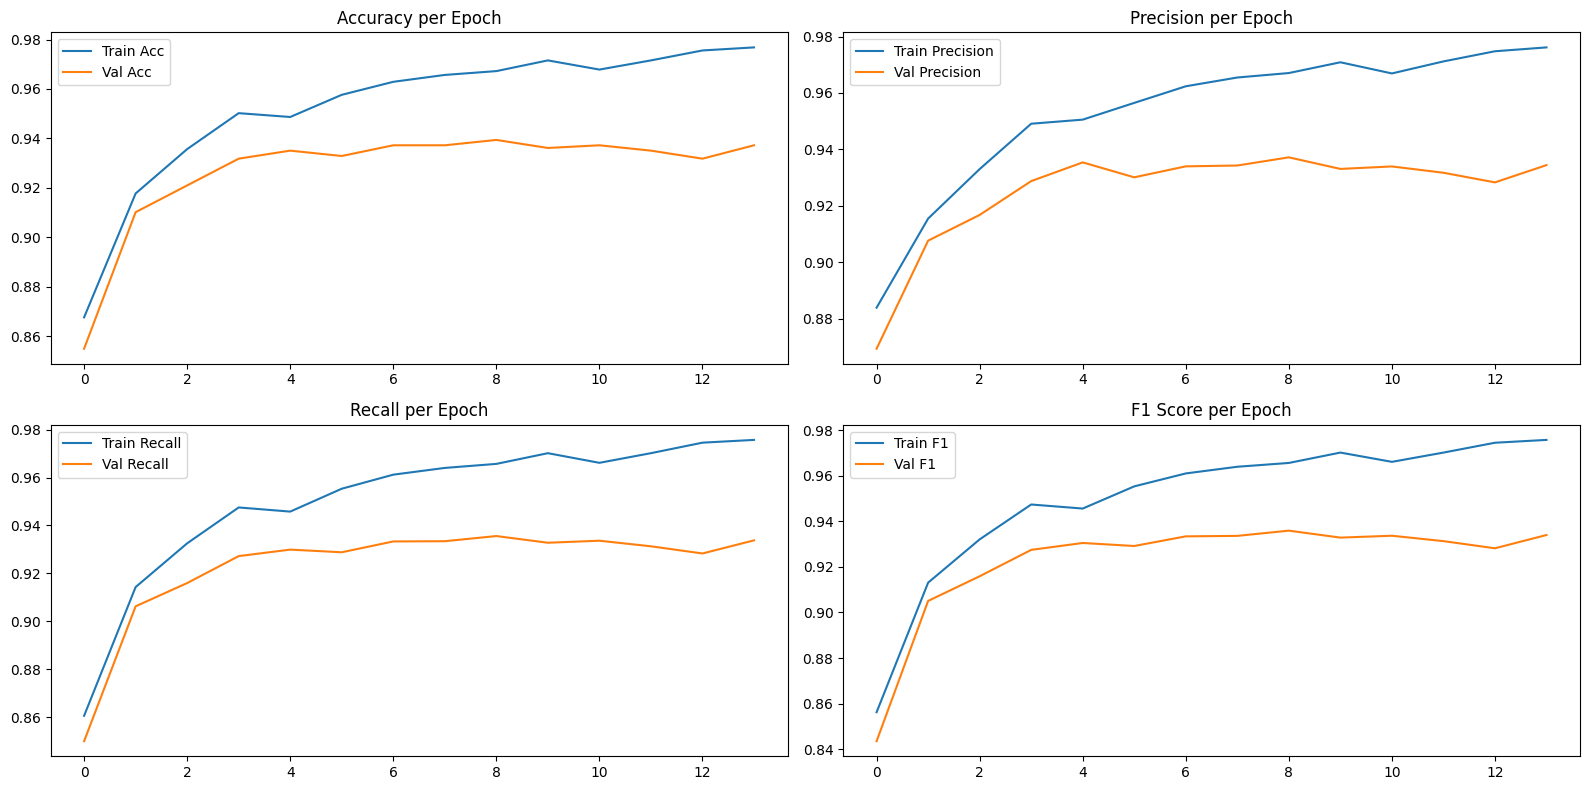

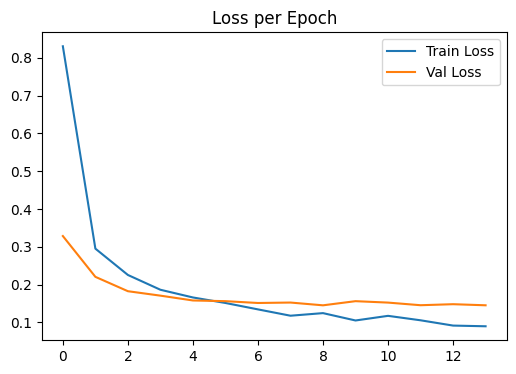

In [18]:
#Plot Metrics

plt.figure(figsize=(16, 8))

plt.subplot(2, 2, 1)
plt.plot(metrics_callback.acc, label='Train Acc')
plt.plot(metrics_callback.val_acc, label='Val Acc')
plt.title("Accuracy per Epoch")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(metrics_callback.precision, label='Train Precision')
plt.plot(metrics_callback.val_precision, label='Val Precision')
plt.title("Precision per Epoch")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(metrics_callback.recall, label='Train Recall')
plt.plot(metrics_callback.val_recall, label='Val Recall')
plt.title("Recall per Epoch")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(metrics_callback.f1, label='Train F1')
plt.plot(metrics_callback.val_f1, label='Val F1')
plt.title("F1 Score per Epoch")
plt.legend()

plt.tight_layout()
plt.show()


#Plot Loss

plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss per Epoch")
plt.legend()
plt.show()

In [19]:
print("Final Scores (Last Epoch):")
print(f"Train Accuracy:  {metrics_callback.acc[-1]:.4f} | Val Accuracy:  {metrics_callback.val_acc[-1]:.4f}")
print(f"Train Precision: {metrics_callback.precision[-1]:.4f} | Val Precision: {metrics_callback.val_precision[-1]:.4f}")
print(f"Train Recall:    {metrics_callback.recall[-1]:.4f} | Val Recall: {metrics_callback.val_recall[-1]:.4f}")
print(f"Train F1:        {metrics_callback.f1[-1]:.4f} | Val F1: {metrics_callback.val_f1[-1]:.4f}")

Final Scores (Last Epoch):
Train Accuracy:  0.9768 | Val Accuracy:  0.9372
Train Precision: 0.9762 | Val Precision: 0.9344
Train Recall:    0.9757 | Val Recall: 0.9338
Train F1:        0.9757 | Val F1: 0.9340


# Model Testing


In [20]:
loss, accuracy = model.evaluate(X_test, y_test, batch_size=64)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9483 - loss: 0.1192
Test Loss: 0.1117
Test Accuracy: 0.9545


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Prediction Accuracy: 0.9545454545454546


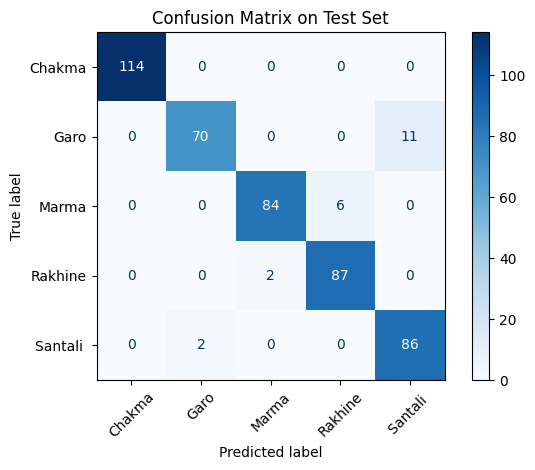

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       114
           1       0.97      0.86      0.92        81
           2       0.98      0.93      0.95        90
           3       0.94      0.98      0.96        89
           4       0.89      0.98      0.93        88

    accuracy                           0.95       462
   macro avg       0.95      0.95      0.95       462
weighted avg       0.96      0.95      0.95       462



In [21]:
y_pred = model.predict(X_test)

y_test_labels = np.argmax(y_test, axis=1)

y_pred_classes = np.argmax(y_pred, axis=1)

class_names = le.classes_

accuracy = accuracy_score(y_test_labels, y_pred_classes)
print('Prediction Accuracy:', accuracy)

cm = confusion_matrix(y_test_labels, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()

print('Classification Report:')
print(classification_report(y_test_labels, y_pred_classes))

# ***END***